# Classification and Clustering of Text articles

## Setup

In [0]:
# importing Libraries

import pandas as pd
import numpy as np
import string
import re
import nltk
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import t
from collections import defaultdict
from sklearn.preprocessing import normalize

In [0]:
train_data = pd.read_json('data/train.json')
validation_data = pd.read_json('data/validation.json')

In [0]:
train_data.head()

,body,category,title
0,"Every day, cubicle-dwellers get up from their ...",4,MobileAccess Networks Strengthens Signals for ...
1,New 1.8-inch hard drives may boost battery lif...,4,Hitachi Drives Consumer Storage
2,A hearing into allegations of racism against t...,1,Cricket: Zim race probe halted
3,The prospect that a tropical storm and a hurri...,4,Simultaneous Tropical Storms are Very Rare
4,Second seed Jiri Novak and number three Guille...,2,NOVAK AND CANAS SET UP SHOWDOWN


In [0]:
validation_data.head()

,category,body,title
0,4,The first targeted flyby of Titan occurs on Tu...,Titan flyby overview
1,1,Officials can not estimate all casualties as s...,Dubai terminal construction collapse
2,4,A patch has been issued for the JpegOfDeath ho...,Will JpegOfDeath Help Slay Microsoft?
3,3,"Marsh amp; McLennan Companies Inc., the insur...",Update 2: Marsh Seeks Incentive Fees for Settl...
4,4,A Singaporean IT products distributor is intro...,PC distributor puts RFID tags in goods


In [0]:
# Tokenization

def text_to_words(text):
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    return text.translate(replace_punctuation).lower().split()

In [0]:
# Get all of terms in data set

def get_vocabulary(data):
    terms = set()
    for doc_idx in data.index:
        body_words = text_to_words(data.loc[doc_idx].body)
        title_words = text_to_words(data.loc[doc_idx].title)
        terms.update(body_words + title_words)
    return list(terms)

In [0]:
# Building static tf-idf dicts

def build_tf(data, terms): 
    n = data.shape[0]
    v = len(terms)
    weight_matrix = np.zeros((n, v))
    
    for doc_idx in data.index:
        doc = data.loc[doc_idx]
        body_words = text_to_words(doc.body)
        title_words = text_to_words(doc.title)
        weight_matrix[doc_idx] = np.zeros(v)
        for w in set(body_words + title_words):
            if w in terms:
                weight_matrix[doc_idx][terms.index(w)] = body_words.count(w) + title_words.count(w)
    
    return pd.DataFrame(weight_matrix, index=data.index, columns=terms)

In [0]:
# Extracting all terms from train data

terms = get_vocabulary(train_data)

In [0]:
x_train = build_tf(train_data, terms)
tf_mat = x_train.copy()

In [0]:
x_val = build_tf(validation_data, terms)

In [0]:
# document frequency per term

df = x_train.astype(bool).sum(axis=0)
df = np.log10(train_data.shape[0] / df)

In [0]:
x_train = df * x_train
y_train = train_data['category']

x_val = df * x_val
y_val = validation_data['category']

In [0]:
categories = ['World', 'Sports', 'Business', 'Sci/Tech']

## Evaluation Functions

In [0]:
def confusion_matrix(y_true, y_pred, categories):
    conf_mat = np.zeros((len(categories), len(categories)))
    for i in range(len(categories)):
        for j in range(len(categories)):
            conf_mat[i][j] = np.count_nonzero((y_pred == i + 1) & (y_true == j  + 1).to_numpy())    
    return pd.DataFrame(conf_mat, index=['Predicted ' + cat for cat in categories], columns=['True ' + cat for cat in categories])

In [0]:
def accuracy(y_true, y_pred):
    diff = (y_true == y_pred).to_numpy()
    return np.count_nonzero(diff) / len(y_true)

In [0]:
def precision_recall(y_true, y_pred, categories):
    conf_mat = confusion_matrix(y_true, y_pred, categories)
    recall = np.zeros(len(categories))
    precision = np.zeros(len(categories))
    
    for i in range(len(categories)):
        precision[i] = conf_mat.values[i][i] / conf_mat.sum(axis=0).iloc[i]
        recall[i] = conf_mat.values[i][i] / conf_mat.sum(axis=1).iloc[i]
    
    recall = pd.DataFrame(recall, index=categories)  
    precision = pd.DataFrame(precision, index=categories)  
    return recall, precision

In [0]:
def macro_f1(y_true, y_pred, categories):
    recall, precision = precision_recall(y_val, y_pred, categories)
    p_avg = np.mean(precision.values)
    r_avg = np.mean(recall.values)
    return 2 * p_avg * r_avg / (p_avg + r_avg)

## Classification

### Naive-Bayes


#### Class Implementation


In [0]:
class Naive_Bayes:
  def __init__(self, alpha):
      self.alpha = alpha
    
  def predict(self, x_test, base_terms):
      test_pred = pd.DataFrame(columns = ['category'], index = x_test.index)
      for doc_idx in x_test.index:
        doc = x_test.loc[doc_idx]
        terms = list(set(text_to_words(doc.body) + text_to_words(doc.title)) & set(base_terms))
        scores = np.zeros(self.class_probs.shape[0])
        for i in range(scores.shape[0]):
            scores[i] = self.class_probs.loc[i + 1] + self.term_probs[terms].sum(axis=1).loc[i + 1]
        test_pred.loc[doc_idx] = np.argmax(scores) + 1                         
      return test_pred['category']

  def fit(self, x, y):
      self.class_probs = np.log10(y.value_counts() / y.shape[0])
      nominator = np.log10(x.groupby(y).sum() + self.alpha)
      denominator = np.log10(x.groupby(y).sum().sum(axis=1) + self.alpha * x.shape[0])
      self.term_probs = nominator.sub(denominator, axis = 0)


#### Evaluation


In [0]:
print("Naive-Bayes with different smoothing coefficients")
best_nb = None
best_acc = 0.0

alpha = [10, 1, 0.1, 0.01, 0.001]
for a in alpha:
    nb_model = Naive_Bayes(alpha = a)
    nb_model.fit(tf_mat, y_train)
    y_pred = nb_model.predict(validation_data, terms)
    acc = accuracy(y_val, y_pred)
    if acc > best_acc:
        best_nb = nb_model
        best_acc = acc
    print("NB Accuracy with alpha", a, "=", acc)

Naive-Bayes with different smoothing coefficients
NB Accuracy with alpha 10 = 0.873
NB Accuracy with alpha 1 = 0.885
NB Accuracy with alpha 0.1 = 0.888
NB Accuracy with alpha 0.01 = 0.877
NB Accuracy with alpha 0.001 = 0.8696666666666667


The above cell shows that the best smoothing coefficient is $\alpha = 0.1$ with $acc = 0.888$

In [0]:
# Evaluating best Naive-bayes classifier

y_pred = best_nb.predict(validation_data, terms)
print("Accuracy = ", accuracy(y_val, y_pred))
print("\nConfusion Matrix = ")
print(confusion_matrix(y_val, y_pred, categories))
recall, precision = precision_recall(y_val, y_pred, categories)
print("\nPrecision per class = ")
print(precision)
print("\nRecall per class = ")
print(recall)
print("\nMacro Average F1 score with B=1 = ")
print(macro_f1(y_val, y_pred, categories))

Accuracy =  0.888

Confusion Matrix = 
                    True World  True Sports  True Business  True Sci/Tech
Predicted World          663.0         11.0           39.0           28.0
Predicted Sports          27.0        729.0            8.0            7.0
Predicted Business        27.0          5.0          622.0           65.0
Predicted Sci/Tech        33.0          5.0           81.0          650.0

Precision per class = 
                 0
World     0.884000
Sports    0.972000
Business  0.829333
Sci/Tech  0.866667

Recall per class = 
                 0
World     0.894737
Sports    0.945525
Business  0.865090
Sci/Tech  0.845254

Macro Average F1 score with B=1 = 
0.887825729974319


### K Nearest Neighbor


#### Class Implementation


In [0]:
class KNN:
  def __init__(self, k, method):
      self.k = k
      self.method = method
    

  def predict(self, x_test):
      test_pred = pd.DataFrame(columns = ['category'], index = x_test.index)
      dist_matrix = self.distance_matrix(x_test)
      
      for i in range(0, len(x_test)):
          neighbor_indexes = dist_matrix[i, :].argsort()[0:self.k] 
          majority = self.y.iloc[neighbor_indexes].mode()
          test_pred.at[x_test.index[i], 'category'] = majority.at[0]
          
      return test_pred['category']  

  def distance_matrix(self, x_test): 

      if self.method == 'c':
          x_test_normalized = normalize(x_test, copy=True)
          x_normalized = normalize(self.x, copy=True)
          return 1 - np.dot(x_test_normalized, x_normalized.T) / (np.linalg.norm(x_normalized) * np.linalg.norm(x_test_normalized))

      if self.method == 'e':
          dist_matrix = np.zeros((x_test.shape[0], self.x.shape[0]))
          dist_matrix = - 2 * np.dot(x_test, self.x.T).T
          dist_matrix += np.diag((np.dot(x_test, x_test.T)))
          dist_matrix = dist_matrix.T
          dist_matrix += np.diag((np.dot(self.x, self.x.T)))
          return np.sqrt(dist_matrix)


  def fit(self, x, y):
      self.x = x
      self.y = y   

#### Evaluation


In [0]:
print("KNN with Cosine Similarity metric results")
best_knn = None
best_acc = 0.0
k_vals = [1, 3, 5]

for k in k_vals:
    knn_model = KNN(k=k, method='c')
    knn_model.fit(x_train, y_train)
    y_pred = knn_model.predict(x_val)
    acc = accuracy(y_val, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_knn = knn_model
    print("KNN Accuracy with k", k, "=", acc)  

KNN with Cosine Similarity metric results
KNN Accuracy with k 1 = 0.8343333333333334
KNN Accuracy with k 3 = 0.844
KNN Accuracy with k 5 = 0.8546666666666667


In [0]:
print("KNN with Euclidean Distance metric results")

for k in k_vals:
    knn_model = KNN(k=k, method='e')
    knn_model.fit(x_train, y_train)
    y_pred = knn_model.predict(x_val)
    acc = accuracy(y_val, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_knn = knn_model
    print("KNN Accuracy with k", k, "=", acc)  

KNN with Euclidean Distance metric results
KNN Accuracy with k 1 = 0.7586666666666667
KNN Accuracy with k 3 = 0.7576666666666667
KNN Accuracy with k 5 = 0.7536666666666667


In [0]:
# Evaluating best Naive-bayes classifier

y_pred = best_knn.predict(x_val)
print("Accuracy = ", accuracy(y_val, y_pred))
print("\nConfusion Matrix = ")
print(confusion_matrix(y_val, y_pred, categories))
recall, precision = precision_recall(y_val, y_pred, categories)
print("\nPrecision per class = ")
print(precision)
print("\nRecall per class = ")
print(recall)
print("\nMacro Average F1 score with B=1 = ")
print(macro_f1(y_val, y_pred, categories))

Accuracy =  0.8546666666666667

Confusion Matrix = 
                    True World  True Sports  True Business  True Sci/Tech
Predicted World          652.0         22.0           31.0           40.0
Predicted Sports          36.0        694.0           23.0           23.0
Predicted Business        36.0          9.0          612.0           81.0
Predicted Sci/Tech        26.0         25.0           84.0          606.0

Precision per class = 
                 0
World     0.869333
Sports    0.925333
Business  0.816000
Sci/Tech  0.808000

Recall per class = 
                 0
World     0.875168
Sports    0.894330
Business  0.829268
Sci/Tech  0.817814

Macro Average F1 score with B=1 = 
0.8544057211870921


### Preprocessing Effect


In [0]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

#### Stopword removal


In [0]:
from nltk.corpus import stopwords

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [t for t in tokens if not t in stop_words]

In [0]:
terms = remove_stopwords(terms)

# after this we run the cells in the setup part to build train and validation

In [0]:
# Evaluating best Naive-bayes classifier for data preprocessed with stopword removal

print("Effect of stopword removal on naive-bayes classifier with alpha = 0.1: \n")
nb_model = Naive_Bayes(alpha = 0.1)
nb_model.fit(tf_mat, y_train)
y_pred = nb_model.predict(validation_data, terms)
print("Accuracy = ", accuracy(y_val, y_pred))
print("\nConfusion Matrix = ")
print(confusion_matrix(y_val, y_pred, categories))
recall, precision = precision_recall(y_val, y_pred, categories)
print("\nPrecision per class = ")
print(precision)
print("\nRecall per class = ")
print(recall)
print("\nMacro Average F1 score with B=1 = ")
print(macro_f1(y_val, y_pred, categories))

Effect of stopword removal on naive-bayes classifier with alpha = 0.1: 

Accuracy =  0.888

Confusion Matrix = 
                    True World  True Sports  True Business  True Sci/Tech
Predicted World          659.0         12.0           35.0           28.0
Predicted Sports          28.0        727.0            8.0            9.0
Predicted Business        30.0          5.0          630.0           65.0
Predicted Sci/Tech        33.0          6.0           77.0          648.0

Precision per class = 
                 0
World     0.878667
Sports    0.969333
Business  0.840000
Sci/Tech  0.864000

Recall per class = 
                 0
World     0.897820
Sports    0.941710
Business  0.863014
Sci/Tech  0.848168

Macro Average F1 score with B=1 = 
0.8878388765132529


We can see that removing stopwords improves precision in 'Business' category by near 2% but does not have a significant effect on other classes(less than 1% decrease). Recalls, F1, and accuracy are almost the same.

In [0]:
# Evaluating best KNN classifier for data preprocessed with stopword removal
# As stated in the doc, I only choosed this method for knn

print("Effect of stopword removal on knn classifier with k = 5: \n")
knn_model = KNN(k=5, method='c')
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_val)
print("Accuracy = ", accuracy(y_val, y_pred))
print("\nConfusion Matrix = ")
print(confusion_matrix(y_val, y_pred, categories))
recall, precision = precision_recall(y_val, y_pred, categories)
print("\nPrecision per class = ")
print(precision)
print("\nRecall per class = ")
print(recall)
print("\nMacro Average F1 score with B=1 = ")
print(macro_f1(y_val, y_pred, categories))

Effect of stopword removal on knn classifier with k = 5: 

Accuracy =  0.8543333333333333

Confusion Matrix = 
                    True World  True Sports  True Business  True Sci/Tech
Predicted World          648.0         23.0           44.0           46.0
Predicted Sports          33.0        705.0           21.0           22.0
Predicted Business        43.0         13.0          612.0           84.0
Predicted Sci/Tech        26.0          9.0           73.0          598.0

Precision per class = 
                 0
World     0.864000
Sports    0.940000
Business  0.816000
Sci/Tech  0.797333

Recall per class = 
                 0
World     0.851511
Sports    0.902689
Business  0.813830
Sci/Tech  0.847025

Macro Average F1 score with B=1 = 
0.8540484858426504


We can see that by using knn, the precision of 'Sports' category improves by 2% and recall of 'Sci/Tech' class improves by 3% but recall of 'World' class is reduced by 2%. F1 and accuracy are almost the same.

#### Lemmatization

In [0]:
from nltk.stem import WordNetLemmatizer

def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return list(set(tokens))

In [0]:
terms = lemmatize_text(terms)

# after this we run the cells in the setup part to build train and validation

In [0]:
# Evaluating best Naive-bayes classifier for data preprocessed with lemmatization

print("Effect of lemmatization on naive-bayes classifier with alpha = 0.1: \n")
nb_model = Naive_Bayes(alpha = 0.1)
nb_model.fit(tf_mat, y_train)
y_pred = nb_model.predict(validation_data, terms)
print("Accuracy = ", accuracy(y_val, y_pred))
print("\nConfusion Matrix = ")
print(confusion_matrix(y_val, y_pred, categories))
recall, precision = precision_recall(y_val, y_pred, categories)
print("\nPrecision per class = ")
print(precision)
print("\nRecall per class = ")
print(recall)
print("\nMacro Average F1 score with B=1 = ")
print(macro_f1(y_val, y_pred, categories))

Effect of lemmatization on naive-bayes classifier with alpha = 0.1: 

Accuracy =  0.8736666666666667

Confusion Matrix = 
                    True World  True Sports  True Business  True Sci/Tech
Predicted World          651.0         13.0           47.0           30.0
Predicted Sports          30.0        727.0           11.0           10.0
Predicted Business        35.0          3.0          607.0           74.0
Predicted Sci/Tech        34.0          7.0           85.0          636.0

Precision per class = 
                 0
World     0.868000
Sports    0.969333
Business  0.809333
Sci/Tech  0.848000

Recall per class = 
                 0
World     0.878543
Sports    0.934447
Business  0.844228
Sci/Tech  0.834646

Macro Average F1 score with B=1 = 
0.8733161395984365


We can see that lemmatization have decreseaed the overall accuracy by about 1 percent. We can see the maximum precision and recall decrease in 'Business' category.

#### Stemming

In [0]:
from nltk.stem import PorterStemmer

def stem_text(tokens):
    stemmer = PorterStemmer() 
    tokens = [stemmer.stem(t) for t in tokens]
    return list(set(tokens))

In [0]:
terms = stem_text(terms)

# after this we run the cells in the setup part to build train and validation

In [57]:
# Evaluating best Naive-bayes classifier for data preprocessed with stemming

print("Effect of stemming on naive-bayes classifier with alpha = 0.1: \n")
nb_model = Naive_Bayes(alpha = 0.1)
nb_model.fit(tf_mat, y_train)
y_pred = nb_model.predict(validation_data, terms)
print("Accuracy = ", accuracy(y_val, y_pred))
print("\nConfusion Matrix = ")
print(confusion_matrix(y_val, y_pred, categories))
recall, precision = precision_recall(y_val, y_pred, categories)
print("\nPrecision per class = ")
print(precision)
print("\nRecall per class = ")
print(recall)
print("\nMacro Average F1 score with B=1 = ")
print(macro_f1(y_val, y_pred, categories))

Effect of stemming on naive-bayes classifier with alpha = 0.1: 

Accuracy =  0.8563333333333333

Confusion Matrix = 
                    True World  True Sports  True Business  True Sci/Tech
Predicted World          646.0         17.0           53.0           33.0
Predicted Sports          30.0        704.0           11.0            7.0
Predicted Business        34.0          6.0          568.0           59.0
Predicted Sci/Tech        40.0         23.0          118.0          651.0

Precision per class = 
                 0
World     0.861333
Sports    0.938667
Business  0.757333
Sci/Tech  0.868000

Recall per class = 
                 0
World     0.862483
Sports    0.936170
Business  0.851574
Sci/Tech  0.782452

Macro Average F1 score with B=1 = 
0.8572506404677097


We can see that stemming have decreseaed the overall accuracy by about 3 percent which is the least among all other preprocessing methods. The most significant effect is in the precision of 'Business' and recall of 'Sci/Tech' category which are reduced by 7% and 6% respectively. 

#### Results

We can conclude that Stopword removal has the best effect on overall performance of the model for this dataset and Stemming has the worst effect.

### SVM


In [0]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Hyper-parameter tuning with GridSearchCV for LinearSVC 

params = {'C': [0.1, 0.01, 0.001, 0.0001]}
svm_model = svm.LinearSVC(random_state=0)
svm_model = GridSearchCV(estimator = svm_model, param_grid = params, cv = 5)

svm_model.fit(x_train, y_train)
print("Best params = ", svm_model.best_params_)

Best params =  {'C': 0.001}


In [0]:
y_pred = svm_model.predict(x_val)
print("Validation accuracy = ", accuracy(y_val, y_pred))

Validation accuracy =  0.893


### Random Forest


In [0]:
from sklearn.ensemble import RandomForestClassifier

# Hyper-parameter tuning with GridSearchCV for Random Forest

n_estimators = [300, 400, 500]
max_depth = [15, 20, 25]

params = {'n_estimators': n_estimators, 
          'max_depth': max_depth,}

rf_model = RandomForestClassifier()
rf_model = GridSearchCV(estimator = rf_model, param_grid = params, cv = 5)
rf_model.fit(x_train, y_train)

print("Best params = ", rf_model.best_params_)

Best params =  {'max_depth': 25, 'n_estimators': 400}


In [0]:
y_pred = rf_model.predict(x_val)
print("Validation accuracy = ", accuracy(y_val, y_pred))

Validation accuracy =  0.826


### Accuracy on test data

The best classifier (Naive-Bayes with alpha = 0.1) is in the model.py file. 

## Clustering

### K-means

In [0]:
class K_Means:
    
  def __init__(self, k, threshold = 0.01, max_iter = 30):
      self.k = k
      self.threshold = threshold
      self.max_iter = max_iter
    

  def cluster(self):
      prev_centroids = pd.DataFrame() 
      y_pred = pd.DataFrame(columns = ['category'], index = self.x.index)   
      iters = 0  
        
      while not prev_centroids.equals(self.centroids) and iters < self.max_iter:
            print("Iteration = ", iters)
            dist_matrix = pd.DataFrame(self.distance_matrix(self.x, self.centroids), columns=self.x.index, index=np.arange(self.k))
            y_pred = dist_matrix.idxmin(axis=0)
            prev_centroids = self.centroids
            self.centroids = self.x.groupby(y_pred).agg(np.mean) 
            iters = iters + 1
            print(y_pred.value_counts())
      
      return y_pred

  def distance_matrix(self, x2, x1): 
      x1_normalized = normalize(x1, copy=True)
      x2_normalized = normalize(x2, copy=True)
      return 1 - np.dot(x1, x2.T) / (np.linalg.norm(x1) * np.linalg.norm(x2))
          

  def fit(self, x):
      self.x = x
      x_mean = self.x.mean(axis=0)
      x_std = self.x.std(axis=0)
      a = np.random.rand(self.k, x.shape[1])
      self.centroids = pd.DataFrame(np.random.rand(self.k, x.shape[1]) * x_std.values + x_mean.values, columns=x.columns)

### Evaluation

In [0]:
km_model = K_Means(k=4)
km_model.fit(x_train)
y_pred = km_model.cluster()

Iteration =  0
1    2938
0    2770
3    2254
2    2038
dtype: int64
Iteration =  1
0    2970
3    2849
1    2320
2    1861
dtype: int64
Iteration =  2
3    3040
0    2820
1    2190
2    1950
dtype: int64
Iteration =  3
3    3114
0    2619
1    2309
2    1958
dtype: int64
Iteration =  4
3    3106
0    2622
1    2316
2    1956
dtype: int64
Iteration =  5
3    3058
0    2634
1    2338
2    1970
dtype: int64
Iteration =  6
3    3030
0    2641
1    2329
2    2000
dtype: int64
Iteration =  7
3    3016
0    2641
1    2315
2    2028
dtype: int64
Iteration =  8
3    3016
0    2638
1    2281
2    2065
dtype: int64
Iteration =  9
3    3013
0    2653
1    2255
2    2079
dtype: int64
Iteration =  10
3    3004
0    2669
1    2236
2    2091
dtype: int64
Iteration =  11
3    2997
0    2684
1    2227
2    2092
dtype: int64
Iteration =  12
3    2993
0    2705
1    2208
2    2094
dtype: int64
Iteration =  13
3    2988
0    2722
1    2199
2    2091
dtype: int64
Iteration =  14
3    2976
0    2773
1    218

We can see that the k-means algorithm stopped after 28 iterations. 

**Note** : Due to timing issues, only 10000 of the training data is used for this clustering. 

In [0]:
# selecting a subset of each class

index = []
for i in range(4):
    index.extend(y_pred.where(y_pred == i).dropna().sample(200, replace=False).index)
    
y_pred.value_counts()

3    2938
0    2790
1    2146
2    2126
dtype: int64

### t-SNE

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 800 samples in 1.451s...
[t-SNE] Computed neighbors for 800 samples in 33.700s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 4.110631
[t-SNE] KL divergence after 250 iterations with early exaggeration: 154.740997
[t-SNE] KL divergence after 700 iterations: 2.564013


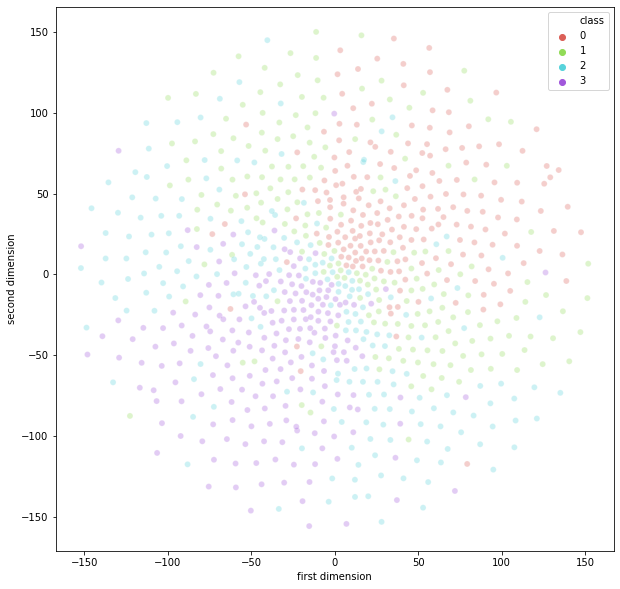

In [0]:
from sklearn.manifold import TSNE

from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt


subset = x_train.loc[index]
subset['class'] = y_pred.loc[index]
data_subset = subset.values


tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=700)
tsne_results = tsne.fit_transform(data_subset)

subset['first dimension'] = tsne_results[:,0]
subset['second dimension'] = tsne_results[:,1]
plt.figure(figsize=(10,10))

sns.scatterplot(data=subset, x='first dimension', y='second dimension', hue='class', 
                palette=sns.color_palette("hls", 4), legend="full", alpha=0.3)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 800 samples in 1.560s...
[t-SNE] Computed neighbors for 800 samples in 22.100s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 5.920520
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.733635
[t-SNE] KL divergence after 700 iterations: 0.499559


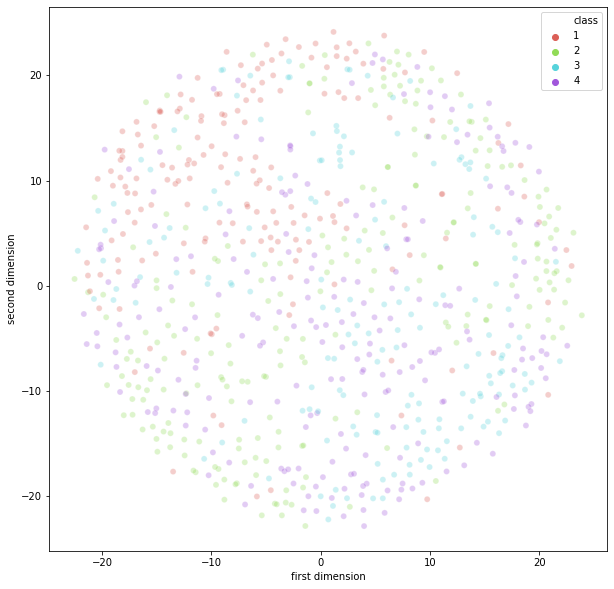

In [0]:
# Checking if the real y's are also clustered well with tsne

subset['class'] = y_train.loc[index]
data_subset = subset.values

tsne_results = tsne.fit_transform(data_subset)

subset['first dimension'] = tsne_results[:,0]
subset['second dimension'] = tsne_results[:,1]
plt.figure(figsize=(10,10))

sns.scatterplot(data=subset, x='first dimension', y='second dimension', hue='class', 
                palette=sns.color_palette("hls", 4), legend="full", alpha=0.3)

By comparing these two plots, we can see that

> 1. We can see that the purple and red classes clusters are better seperated than the other two classes in the first plot.
> 2. K-means have clustered a larger portion of the data in classes 0 and 3 (purple and red) 
> 3. In the second plot, we can see that our k-means have done a better job in clustering world and sci-tech classes but overally it did not have a good performance compared to the next part.




## Word2Vec

In [0]:
from gensim.utils import simple_preprocess

# building list of list of tokens in docs

doc_list = []
for i in train_data.index:
    content = train_data.iloc[i].body + train_data.iloc[i].title
    doc_list.append(text_to_words(content))

In [115]:
from gensim.models import Word2Vec

# building word2vec model

w2v_model = Word2Vec(doc_list, window=5, size=100, min_count=1)
x = w2v_model[w2v_model.wv.vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [116]:
# building feature vectors for docs

x_train = np.zeros((train_data.shape[0], x.shape[1]))

for i in train_data.index:
    vec = np.zeros(x.shape[1])
    for term in doc_list[i]:
        vec += w2v_model[term]
    x_train[i] = vec / len(doc_list[i])

x_train = pd.DataFrame(x_train)  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### Evaluation

In [99]:
from nltk.cluster import KMeansClusterer

kclusterer = KMeansClusterer(4, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(x_train, assign_clusters=True)

[2, 1, 2, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 1, 3, 3, 3, 3, 2, 1, 2, 3, 1, 3, 1, 3, 1, 2, 3, 1, 2, 2, 0, 2, 1, 3, 3, 3, 0, 3, 2, 2, 1, 1, 2, 3, 3, 3, 1, 2, 3, 1, 3, 2, 3, 2, 2, 1, 2, 1, 2, 2, 3, 1, 3, 1, 2, 3, 2, 0, 1, 1, 3, 2, 1, 3, 1, 3, 2, 3, 3, 1, 2, 3, 1, 3, 3, 3, 1, 2, 3, 2, 3, 1, 2, 2, 2, 3, 3, 3, 2, 2, 2, 1, 1, 3, 3, 3, 2, 3, 2, 2, 3, 1, 3, 2, 0, 3, 0, 3, 2, 2, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 2, 2, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 3, 3, 2, 1, 3, 0, 3, 2, 1, 3, 1, 2, 3, 2, 1, 1, 3, 1, 3, 1, 3, 0, 2, 2, 3, 3, 1, 3, 3, 2, 3, 2, 1, 2, 2, 3, 1, 2, 1, 3, 3, 3, 1, 3, 3, 2, 0, 3, 2, 3, 2, 2, 3, 2, 3, 1, 1, 1, 2, 1, 0, 3, 3, 1, 3, 1, 2, 3, 3, 1, 2, 3, 3, 1, 3, 1, 2, 3, 3, 3, 1, 2, 2, 1, 2, 3, 2, 2, 3, 3, 1, 3, 1, 1, 3, 3, 3, 2, 2, 1, 1, 1, 1, 3, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 2, 0, 3, 1, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 2, 3, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 1, 3, 2, 1, 3, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 3, 1, 2, 2, 2, 1, 3, 3, 1, 0, 1, 1, 2, 

In [0]:
km_w2v_model = K_Means(k=4)
km_w2v_model.fit(x_train)
y_pred = km_w2v_model.cluster()

In [0]:
# selecting a subset of each class

index = []
y_pred = pd.Series(assigned_clusters)
for i in range(4):
    index.extend(y_pred.where(y_pred == i).dropna().sample(200, replace=False).index)
    
y_pred.value_counts()

3    3847
1    2930
2    2915
0     308
dtype: int64

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.007s...
[t-SNE] Computed neighbors for 800 samples in 0.088s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 0.396931
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.880756
[t-SNE] KL divergence after 700 iterations: 0.441108


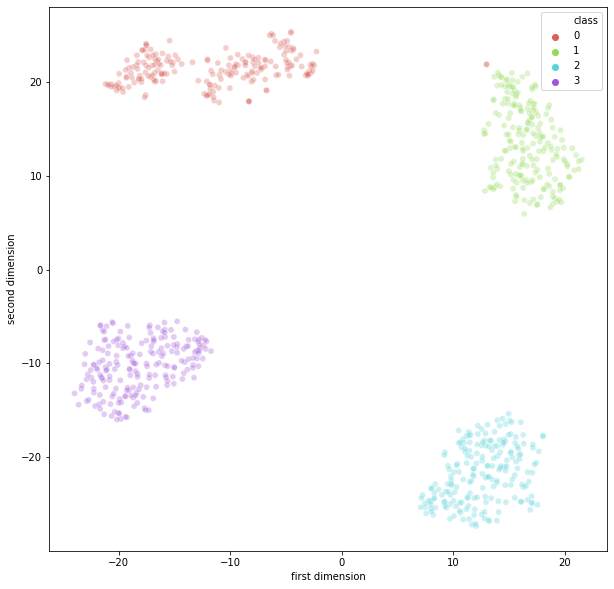

In [111]:
subset = x_train.loc[index]
subset['class'] = y_pred.loc[index]
data_subset = subset.values


tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=700)
tsne_results = tsne.fit_transform(data_subset)

subset['first dimension'] = tsne_results[:,0]
subset['second dimension'] = tsne_results[:,1]
plt.figure(figsize=(10,10))

sns.scatterplot(data=subset, x='first dimension', y='second dimension', hue='class', 
                palette=sns.color_palette("hls", 4), legend="full", alpha=0.3)

We can see that word2vec representation is much better classified using K-means algorithm. The 4 clusters are well seperated and there is only one red outlier in green cluster.

### Effect of hyper-parameters

**Note**: For this part, I used KMeansClusterer from nltk to make the process of running kmeans faster.  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[3, 1, 2, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 1, 3, 3, 3, 3, 1, 1, 2, 3, 1, 3, 1, 3, 1, 2, 3, 1, 2, 2, 0, 2, 1, 3, 3, 3, 0, 3, 3, 2, 1, 1, 3, 3, 3, 3, 1, 2, 3, 1, 3, 2, 3, 2, 2, 1, 2, 1, 2, 2, 3, 1, 3, 1, 2, 3, 2, 0, 1, 1, 3, 2, 1, 3, 1, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 2, 3, 2, 3, 1, 2, 2, 1, 3, 3, 3, 2, 2, 2, 1, 1, 3, 3, 3, 2, 3, 1, 2, 3, 1, 3, 2, 0, 3, 0, 3, 2, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 2, 2, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 3, 3, 2, 1, 3, 0, 3, 2, 1, 1, 1, 2, 3, 2, 1, 1, 3, 1, 3, 1, 3, 0, 2, 2, 3, 3, 1, 2, 3, 3, 1, 2, 1, 2, 2, 3, 1, 2, 1, 3, 3, 2, 1, 3, 3, 2, 0, 3, 2, 2, 2, 2, 3, 2, 3, 1, 1, 1, 2, 1, 0, 3, 3, 1, 3, 1, 2, 3, 3, 1, 2, 3, 3, 1, 3, 1, 2, 3, 3, 3, 1, 2, 2, 1, 2, 3, 2, 2, 1, 3, 1, 3, 1, 1, 3, 3, 3, 2, 2, 1, 1, 1, 3, 3, 2, 2, 3, 3, 3, 1, 1, 1, 1, 3, 2, 0, 3, 1, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 2, 3, 2, 3, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 1, 3, 2, 1, 3, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 3, 1, 2, 3, 2, 1, 3, 3, 1, 0, 1, 1, 2, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[2, 1, 2, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 1, 3, 3, 3, 3, 2, 1, 2, 3, 1, 3, 1, 3, 1, 2, 3, 1, 2, 2, 0, 2, 1, 3, 3, 3, 0, 3, 2, 2, 1, 1, 2, 3, 3, 3, 1, 2, 3, 1, 3, 2, 3, 2, 2, 1, 2, 1, 2, 2, 3, 1, 3, 1, 2, 3, 2, 0, 1, 1, 3, 2, 1, 3, 1, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 2, 3, 2, 3, 1, 2, 2, 2, 1, 3, 3, 2, 2, 2, 1, 1, 3, 3, 3, 2, 3, 1, 2, 3, 1, 3, 2, 0, 3, 0, 3, 2, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 2, 2, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 3, 2, 3, 3, 2, 1, 1, 0, 3, 2, 1, 3, 1, 2, 3, 2, 1, 1, 3, 1, 3, 1, 3, 0, 2, 2, 3, 3, 1, 2, 3, 1, 1, 2, 1, 2, 2, 3, 1, 2, 1, 3, 3, 3, 1, 3, 3, 2, 0, 3, 2, 2, 2, 2, 3, 2, 3, 1, 1, 1, 1, 1, 0, 3, 3, 1, 3, 1, 2, 3, 3, 1, 2, 3, 3, 1, 3, 1, 2, 3, 3, 3, 1, 2, 2, 1, 2, 3, 2, 2, 1, 3, 1, 3, 1, 1, 3, 3, 3, 2, 2, 1, 1, 1, 1, 3, 3, 2, 3, 3, 1, 1, 1, 1, 1, 3, 2, 0, 3, 1, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 2, 3, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 1, 3, 2, 1, 3, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 3, 1, 2, 2, 2, 1, 3, 3, 1, 0, 1, 1, 2, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[2, 1, 2, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 1, 3, 3, 3, 3, 1, 1, 2, 3, 1, 3, 1, 3, 1, 2, 3, 1, 2, 2, 0, 2, 1, 3, 3, 3, 0, 3, 2, 2, 1, 1, 2, 3, 3, 3, 1, 2, 3, 1, 3, 2, 3, 2, 2, 1, 2, 1, 2, 2, 3, 1, 3, 1, 2, 3, 2, 0, 1, 1, 3, 2, 1, 3, 1, 3, 2, 3, 3, 1, 2, 3, 1, 3, 3, 3, 1, 2, 3, 2, 1, 1, 2, 2, 2, 3, 3, 3, 2, 2, 2, 1, 1, 3, 3, 3, 2, 3, 1, 2, 3, 1, 3, 2, 0, 3, 0, 3, 2, 2, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 2, 2, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 3, 3, 2, 1, 1, 0, 3, 2, 1, 3, 1, 2, 3, 2, 1, 1, 3, 1, 3, 1, 3, 0, 2, 2, 3, 3, 1, 3, 3, 2, 3, 2, 1, 2, 2, 3, 1, 2, 1, 3, 3, 3, 1, 3, 3, 2, 0, 3, 2, 2, 2, 2, 3, 2, 3, 1, 1, 1, 2, 1, 0, 3, 3, 1, 3, 1, 2, 3, 3, 1, 2, 3, 3, 1, 3, 1, 2, 3, 3, 3, 1, 2, 2, 1, 3, 3, 2, 2, 3, 3, 0, 3, 1, 1, 3, 3, 3, 2, 2, 1, 1, 1, 1, 3, 3, 2, 3, 3, 1, 1, 1, 1, 1, 3, 2, 0, 3, 1, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 2, 3, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3, 3, 1, 2, 1, 3, 2, 1, 3, 2, 2, 2, 2, 2, 3, 1, 2, 3, 3, 3, 1, 2, 2, 2, 1, 2, 3, 1, 0, 1, 1, 2, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[3, 1, 2, 3, 2, 3, 1, 2, 3, 3, 3, 2, 2, 1, 3, 3, 1, 3, 2, 1, 2, 3, 3, 3, 0, 3, 0, 2, 3, 1, 3, 2, 0, 2, 1, 1, 3, 3, 0, 3, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 1, 1, 2, 1, 2, 2, 1, 3, 1, 2, 2, 3, 1, 3, 1, 2, 3, 2, 0, 1, 0, 1, 2, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 2, 3, 2, 3, 2, 1, 2, 1, 3, 3, 2, 1, 1, 2, 3, 3, 3, 1, 3, 1, 2, 3, 1, 3, 2, 0, 3, 0, 3, 2, 1, 3, 1, 1, 3, 1, 0, 3, 3, 3, 1, 3, 3, 1, 3, 0, 1, 3, 1, 2, 1, 3, 1, 3, 1, 3, 0, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 3, 3, 1, 1, 1, 1, 3, 2, 1, 1, 1, 2, 3, 3, 1, 1, 3, 1, 3, 2, 3, 0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 3, 1, 2, 1, 1, 3, 2, 1, 3, 3, 2, 0, 3, 1, 3, 2, 2, 1, 3, 3, 1, 1, 1, 1, 3, 0, 3, 3, 1, 3, 1, 2, 3, 3, 1, 1, 3, 2, 1, 3, 1, 1, 3, 3, 3, 1, 2, 2, 2, 2, 3, 2, 2, 2, 3, 0, 1, 1, 0, 1, 1, 3, 2, 2, 1, 3, 1, 1, 3, 2, 2, 3, 3, 3, 1, 1, 1, 1, 3, 2, 0, 3, 1, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 3, 3, 2, 1, 1, 1, 1, 0, 1, 1, 2, 3, 3, 1, 2, 1, 3, 2, 1, 3, 2, 1, 1, 3, 1, 2, 1, 2, 3, 3, 3, 0, 1, 3, 2, 3, 3, 3, 1, 0, 0, 1, 1, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[3, 1, 2, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 1, 3, 3, 1, 3, 2, 1, 2, 3, 3, 3, 0, 3, 0, 2, 3, 1, 2, 2, 0, 2, 1, 3, 3, 3, 0, 3, 3, 2, 1, 1, 3, 3, 3, 3, 1, 2, 3, 1, 3, 2, 1, 2, 2, 1, 3, 1, 2, 2, 3, 1, 3, 1, 2, 3, 2, 0, 1, 0, 1, 2, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 2, 3, 2, 2, 2, 1, 2, 1, 3, 3, 2, 1, 1, 2, 3, 3, 3, 1, 3, 1, 2, 3, 1, 3, 2, 0, 3, 0, 3, 2, 1, 3, 1, 1, 3, 1, 0, 3, 3, 3, 1, 3, 3, 1, 3, 0, 1, 3, 1, 2, 1, 3, 1, 3, 1, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 3, 3, 1, 1, 1, 1, 3, 2, 1, 1, 1, 2, 3, 3, 1, 1, 3, 1, 3, 2, 3, 0, 2, 1, 1, 3, 2, 2, 2, 1, 2, 2, 1, 2, 2, 3, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 0, 3, 1, 3, 2, 2, 3, 3, 3, 1, 1, 3, 1, 3, 0, 3, 3, 1, 3, 1, 2, 3, 3, 1, 3, 3, 2, 1, 3, 1, 1, 3, 3, 3, 1, 2, 2, 2, 2, 3, 2, 2, 2, 3, 0, 1, 1, 1, 1, 1, 3, 2, 2, 1, 3, 1, 1, 3, 2, 2, 3, 3, 3, 1, 1, 1, 1, 3, 2, 0, 3, 1, 2, 2, 1, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 2, 1, 3, 2, 1, 3, 2, 1, 1, 3, 1, 2, 1, 2, 3, 3, 3, 0, 1, 3, 2, 3, 3, 3, 1, 0, 0, 1, 1, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[3, 1, 2, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 1, 3, 3, 1, 3, 2, 1, 2, 3, 3, 3, 0, 3, 0, 2, 3, 1, 2, 2, 0, 2, 1, 3, 3, 3, 0, 3, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 1, 3, 2, 1, 2, 2, 1, 3, 1, 2, 2, 3, 1, 3, 1, 2, 3, 2, 0, 1, 0, 1, 2, 1, 3, 1, 1, 2, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 2, 3, 2, 2, 2, 1, 2, 1, 3, 3, 2, 2, 1, 1, 3, 3, 3, 1, 3, 1, 2, 3, 1, 3, 2, 0, 3, 0, 3, 2, 1, 3, 1, 1, 3, 1, 0, 3, 3, 3, 1, 1, 3, 1, 3, 0, 1, 3, 1, 2, 1, 3, 1, 3, 1, 2, 0, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 3, 3, 2, 1, 1, 1, 3, 2, 1, 1, 1, 2, 3, 3, 1, 1, 3, 1, 3, 1, 1, 0, 2, 1, 1, 3, 2, 2, 3, 1, 2, 2, 1, 2, 2, 3, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 0, 3, 1, 3, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 0, 3, 3, 1, 3, 1, 2, 3, 3, 1, 2, 3, 2, 1, 3, 1, 1, 3, 3, 3, 1, 2, 2, 2, 2, 3, 2, 2, 2, 3, 0, 1, 1, 0, 1, 1, 3, 2, 2, 1, 1, 1, 1, 3, 2, 2, 3, 3, 3, 1, 1, 1, 1, 3, 2, 0, 3, 1, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 3, 3, 2, 1, 1, 1, 1, 0, 1, 1, 1, 3, 3, 1, 2, 1, 3, 2, 1, 3, 2, 1, 1, 2, 1, 2, 1, 2, 3, 3, 3, 0, 1, 3, 2, 3, 3, 3, 1, 0, 0, 1, 1, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[1, 0, 3, 3, 2, 3, 0, 3, 1, 3, 3, 2, 3, 1, 3, 3, 1, 3, 2, 0, 3, 3, 3, 3, 0, 3, 0, 3, 2, 2, 3, 3, 0, 2, 2, 1, 3, 3, 0, 3, 1, 3, 1, 1, 1, 3, 3, 2, 0, 3, 3, 1, 1, 3, 1, 3, 2, 1, 3, 1, 2, 2, 1, 1, 3, 1, 3, 3, 2, 0, 0, 0, 1, 3, 0, 1, 1, 1, 3, 3, 3, 1, 3, 2, 1, 3, 3, 3, 0, 1, 3, 3, 3, 2, 1, 2, 0, 2, 1, 3, 3, 3, 1, 0, 2, 1, 3, 2, 1, 1, 1, 3, 3, 2, 3, 2, 0, 1, 0, 3, 2, 0, 1, 2, 1, 1, 1, 0, 3, 3, 3, 1, 1, 1, 1, 3, 0, 0, 1, 2, 2, 1, 3, 0, 3, 1, 3, 0, 3, 3, 2, 2, 3, 1, 0, 0, 2, 2, 3, 3, 1, 2, 1, 1, 3, 2, 2, 1, 0, 3, 3, 3, 1, 1, 3, 2, 3, 2, 3, 0, 2, 0, 1, 1, 2, 3, 2, 2, 2, 2, 0, 3, 3, 1, 1, 2, 0, 1, 3, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 2, 1, 3, 3, 0, 0, 1, 1, 2, 0, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 2, 1, 1, 1, 0, 3, 3, 3, 1, 2, 3, 2, 3, 3, 3, 3, 2, 1, 0, 1, 2, 0, 1, 1, 3, 2, 3, 0, 2, 2, 1, 3, 3, 3, 3, 3, 2, 2, 1, 2, 2, 3, 3, 0, 3, 1, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 1, 1, 1, 2, 3, 3, 3, 1, 0, 0, 1, 0, 2, 0, 2, 3, 3, 1, 3, 0, 3, 3, 0, 3, 3, 1, 1, 3, 1, 3, 1, 2, 3, 3, 3, 0, 1, 1, 2, 3, 3, 3, 0, 0, 0, 1, 1, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[1, 0, 2, 3, 2, 3, 1, 2, 3, 3, 3, 2, 2, 1, 3, 3, 1, 3, 2, 0, 2, 3, 3, 3, 0, 3, 0, 2, 2, 1, 3, 2, 0, 2, 2, 1, 3, 3, 0, 3, 1, 2, 1, 1, 1, 3, 3, 1, 0, 2, 3, 1, 1, 3, 1, 2, 2, 1, 3, 1, 2, 2, 1, 1, 3, 1, 2, 3, 2, 0, 1, 0, 1, 2, 0, 1, 1, 1, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 0, 1, 3, 2, 3, 2, 1, 2, 0, 2, 1, 3, 3, 2, 1, 0, 2, 3, 3, 3, 1, 3, 1, 2, 3, 2, 3, 2, 0, 1, 0, 3, 2, 1, 1, 2, 1, 3, 1, 0, 3, 3, 3, 1, 1, 1, 1, 3, 0, 0, 3, 1, 2, 1, 3, 0, 3, 1, 3, 0, 2, 3, 2, 2, 3, 1, 0, 0, 2, 2, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 0, 2, 3, 3, 1, 3, 3, 2, 3, 2, 1, 0, 2, 0, 1, 1, 2, 3, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 0, 1, 3, 2, 1, 3, 3, 2, 0, 3, 1, 3, 3, 1, 1, 3, 3, 0, 0, 1, 1, 3, 0, 3, 3, 1, 3, 1, 2, 1, 3, 1, 1, 3, 2, 1, 1, 1, 0, 3, 3, 3, 1, 2, 3, 2, 2, 3, 3, 2, 2, 3, 0, 1, 2, 0, 1, 1, 3, 2, 2, 0, 3, 1, 1, 3, 2, 2, 3, 3, 3, 2, 1, 2, 1, 3, 3, 0, 3, 1, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 3, 3, 2, 1, 0, 0, 1, 0, 2, 1, 2, 3, 3, 1, 2, 0, 3, 2, 0, 3, 3, 1, 1, 3, 1, 3, 1, 2, 3, 3, 3, 0, 1, 3, 2, 3, 3, 3, 0, 0, 0, 1, 1, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[1, 0, 2, 3, 2, 3, 1, 2, 3, 3, 3, 2, 2, 1, 3, 3, 1, 3, 2, 0, 2, 3, 3, 3, 0, 3, 0, 2, 2, 1, 3, 2, 0, 2, 2, 1, 3, 3, 0, 3, 1, 2, 1, 1, 1, 3, 3, 1, 0, 2, 3, 1, 1, 2, 1, 2, 2, 1, 3, 1, 2, 2, 1, 1, 3, 1, 2, 3, 2, 0, 1, 0, 1, 2, 0, 1, 1, 1, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 0, 1, 3, 2, 3, 2, 3, 2, 0, 2, 1, 3, 3, 2, 1, 0, 2, 3, 3, 3, 1, 3, 1, 2, 3, 2, 3, 2, 0, 1, 0, 3, 2, 1, 1, 1, 1, 3, 1, 0, 3, 3, 3, 1, 1, 1, 1, 3, 0, 0, 3, 1, 2, 1, 3, 0, 3, 1, 3, 0, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 3, 3, 1, 1, 3, 2, 3, 2, 1, 0, 2, 0, 1, 1, 2, 3, 2, 1, 2, 2, 1, 2, 2, 3, 1, 2, 0, 1, 3, 2, 3, 2, 3, 2, 0, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 0, 3, 3, 1, 3, 1, 2, 1, 3, 1, 1, 3, 2, 1, 1, 1, 0, 3, 3, 3, 1, 2, 3, 2, 2, 3, 3, 2, 2, 3, 0, 1, 2, 0, 1, 1, 3, 2, 2, 0, 3, 1, 1, 3, 2, 2, 3, 3, 3, 2, 1, 2, 1, 3, 2, 0, 3, 1, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 3, 3, 2, 1, 0, 0, 1, 0, 2, 1, 2, 3, 3, 1, 2, 0, 3, 2, 0, 3, 2, 1, 1, 3, 1, 2, 1, 2, 3, 3, 3, 0, 1, 3, 2, 3, 3, 3, 0, 0, 0, 1, 1, 

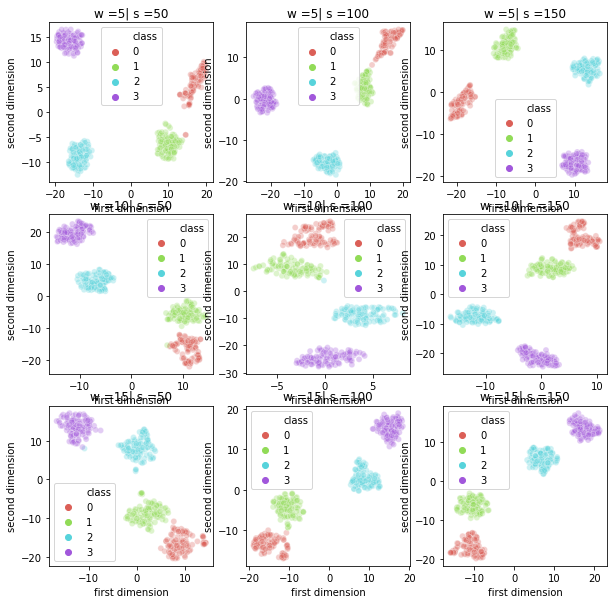

In [145]:
import itertools

windows = [5, 10, 15]
sizes = [50, 100, 150]

plt.figure(figsize=(10,10))

for a in range(len(windows)):
    for j in range(len(sizes)):
        w = windows[a]
        s = sizes[j]
        w2v_model = Word2Vec(doc_list, window=w, size=s, min_count=1)
        x = w2v_model[w2v_model.wv.vocab]

        x_train = np.zeros((train_data.shape[0], x.shape[1]))

        for i in train_data.index:
            vec = np.zeros(x.shape[1])
            for term in doc_list[i]:
                vec += w2v_model[term]
            x_train[i] = vec / len(doc_list[i])

        x_train = pd.DataFrame(x_train)

        kclusterer = KMeansClusterer(4, distance=nltk.cluster.util.cosine_distance, repeats=25)
        assigned_clusters = kclusterer.cluster(x_train.values, assign_clusters=True) 
        print(assigned_clusters)

        index = []
        y_pred = pd.Series(assigned_clusters)
        for i in range(4):
            index.extend(y_pred.where(y_pred == i).dropna().sample(100, replace=False).index)

        subset = x_train.loc[index]
        subset['class'] = y_pred.loc[index]
        data_subset = subset.values

        tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=700)
        tsne_results = tsne.fit_transform(data_subset)

        subset['first dimension'] = tsne_results[:,0]
        subset['second dimension'] = tsne_results[:,1]

        plt.subplot(3, 3, a * 3 + j  + 1).set_title('w =' + str(windows[a]) + '| s =' + str(sizes[j]))
        sns.scatterplot(data=subset, x='first dimension', y='second dimension', hue='class', 
                palette=sns.color_palette("hls", 4), legend="full", alpha=0.3)   
      


As we can see in this 9 plots, the best clustering is for window size of 5 and embedding size of 150. (Please scroll down to see the plots)